In [1]:
%pip install numpy pandas scikit-learn tensorflow


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
# Paths to your data
good_posture_path = "../training_vids/good_posture/csv/"
bad_posture_path = "../training_vids/bad_posture/csv/"

In [7]:
def load_data_with_varying_lengths(path, label):
    data = []
    labels = []

    for file in os.listdir(path):
        if file.endswith(".csv"):
            csv_data = pd.read_csv(os.path.join(path, file))
            data.append(csv_data.values)  # No need to pad/truncate here
            labels.append(label)  # Assign label (0 for bad, 1 for good)

    return data, np.array(labels)

# Combine good and bad data
good_data, good_labels = load_data_with_varying_lengths(good_posture_path, 1)
bad_data, bad_labels = load_data_with_varying_lengths(bad_posture_path, 0)

# Combine good and bad data
data = good_data + bad_data  # List of arrays of varying lengths
labels = np.concatenate((good_labels, bad_labels), axis=0)

In [8]:
X = pad_sequences(data, padding='post', dtype='float32')  # Pad only at the end with zeros

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build the LSTM model with masking, batch normalization, and L2 regularization
model = Sequential()

# Add masking layer to ignore padded values
model.add(Masking(mask_value=0.0, input_shape=(None, X_train.shape[2])))

# Add LSTM layers with L2 regularization
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.002)))  # L2 regularization added
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(64, kernel_regularizer=l2(0.002)))  # L2 regularization added
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Add dense layers with L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.002)))  # L2 regularization added
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.002)))  # L2 regularization added


/home/dele/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
checkpoint = ModelCheckpoint('squat_model.keras', monitor='val_loss', mode='min', save_best_only=True)

In [12]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, checkpoint])
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.4940 - loss: 1.2861 - val_accuracy: 0.5273 - val_loss: 1.0910
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6032 - loss: 1.1368 - val_accuracy: 0.5697 - val_loss: 1.0657
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5679 - loss: 1.1980 - val_accuracy: 0.6364 - val_loss: 1.0485
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6375 - loss: 1.0645 - val_accuracy: 0.6061 - val_loss: 1.0325
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6261 - loss: 1.0292 - val_accuracy: 0.6606 - val_loss: 1.0100
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6349 - loss: 1.0160 - val_accuracy: 0.6727 - val_loss: 0.9974
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6412 - loss: 1.0154 - val_accuracy: 0.6848 - val_loss: 0.9809
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6181 - loss: 1.0341 - val_accuracy: 0.

In [13]:
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"The best model was saved at epoch: {best_epoch}")

The best model was saved at epoch: 83


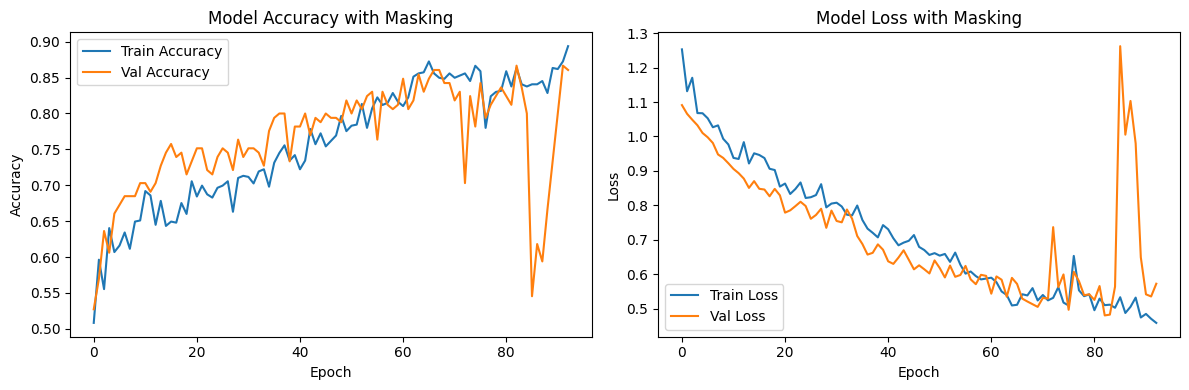

In [15]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy with Masking')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss with Masking')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
#f1 score
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
F1 Score: 0.87


In [59]:
from tensorflow.keras.models import load_model

In [62]:
model = load_model('squat_model.keras')

In [18]:
csv_path = '../training_vids/bad_posture/csv/squat_22.csv'

# Preprocess the CSV data (assuming SEQUENCE_LENGTH is the same as used during training)
SEQUENCE_LENGTH = 100  # Replace with your actual sequence length
csv_data = process_csv(csv_path, SEQUENCE_LENGTH)

# Classify the CSV data
prediction = model.predict(csv_data)
print(f'Prediction {prediction}')
# Output the prediction
if prediction >= 0.5:
    print("Good Posture")
else:
    print("Bad Posture")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction [[0.17231913]]
Bad Posture


In [1]:
from tensorflow.keras.models import load_model

2024-11-05 21:17:57.758149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 21:17:57.773379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 21:17:57.777198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 21:17:57.787825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 21:17:58.729430: W tensorflow/compiler/tf2

In [2]:
model = load_model('squat_model.keras')

I0000 00:00:1730859479.950231 3374740 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-05 21:17:59.967180: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
import pickle
with open('path/to/history.pkl', 'rb') as f:
    history = pickle.load(f)

# Number of epochs used for training
epochs = len(history['loss'])
print("Number of epochs:", epochs)

In [63]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Binarize predictions if it's binary classification

report = classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1'])
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
              precision    recall  f1-score   support

     Class 0       0.87      0.91      0.89        82
     Class 1       0.91      0.87      0.89        83

    accuracy                           0.89       165
   macro avg       0.89      0.89      0.89       165
weighted avg       0.89      0.89      0.89       165



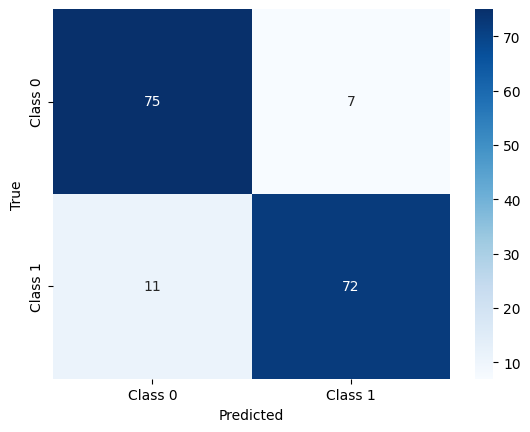

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


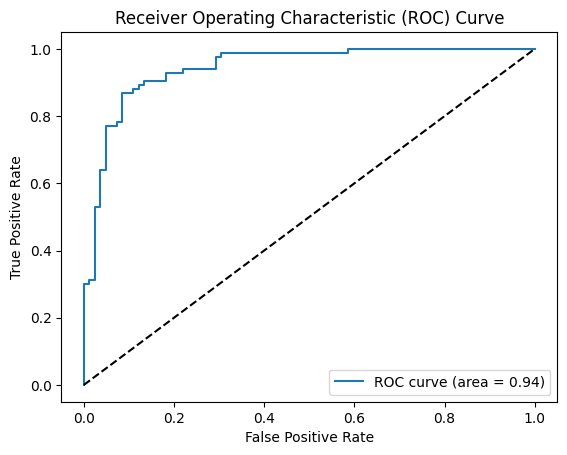

In [67]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()


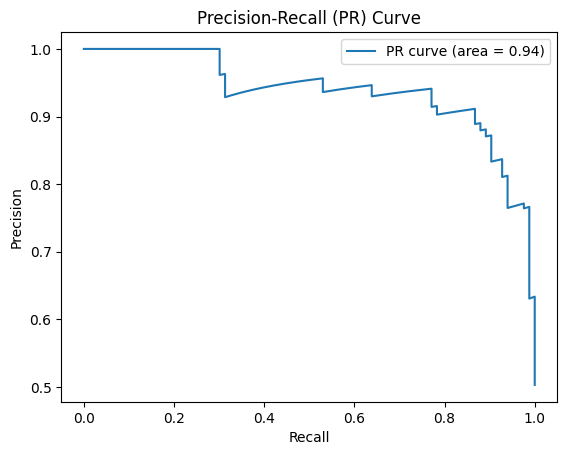

In [68]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)

plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='best')
plt.show()



In [69]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred_classes)
print(f'Matthews Correlation Coefficient: {mcc:.2f}')


Matthews Correlation Coefficient: 0.78
